# Notebook 01: Descarga de datos
## Detección de cambios urbanos en Viña del Mar (2019-2025)

Este notebook automatiza la descarga de imágenes satelitales Sentinel-2 y datos vectoriales censales/administrativos necesarios para el análisis multitemporal.

### Resumen de Datos
A continuación se detallan los insumos geoespaciales que serán descargados y almacenados en la estructura del proyecto:

| Tipo de Dato | Archivo / Patrón | Ubicación Local | Fuente Original | Descripción Técnica |
| :--- | :--- | :--- | :--- | :--- |
| **Imágenes Satelitales** | `sentinel2_{AÑO}.tif` | `data/raw/` | **Google Earth Engine** (Copernicus S2 SR) | Mosaicos anuales generados mediante la mediana temporal. Resolución: 10m. |
| **Límite Administrativo** | `limite_comuna.gpkg` | `data/vector/` | **IDE Chile** (GeoPortal) | Polígono oficial de la División Político Administrativa (DPA 2020). |
| **Censo** | `manzanas_censales.shp` | `data/vector/` | **INE** (API ArcGIS) | Manzanas censales urbanas del Censo 2017 reproyectadas. |
| **Infraestructura** | `red_vial.geojson` | `data/vector/` | **OpenStreetMap** (OSMnx) | Red vial transitable para vehículos (layer 'drive'). |


> **Nota Técnica:** Para el formato Shapefile (`.shp`) del archivo de manzanas censales, la descarga incluye automáticamente sus archivos auxiliares obligatorios (`.shx`, `.dbf`, `.prj`, `.cpg`) para garantizar la integridad geométrica y de atributos.

---

### Justificación del Área y Período de Estudio
* **Zona de Estudio:** Comuna de **Viña del Mar**, Región de Valparaíso, Chile.
    * *Justificación:* Viña del Mar presenta una dinámica urbana compleja, caracterizada por una rápida expansión inmobiliaria, presión sobre áreas verdes y alta vulnerabilidad ante desastres (incendios forestales que ocurrieron en el pasado). Es un caso de estudio ideal para monitorear la pérdida de vegetación y el crecimiento urbano.
* **Período de Análisis (2019-2025):**
    * *Justificación:* Este intervalo temporal de 7 años permite capturar efectos de mediano plazo derivados de eventos socioambientales críticos:
        1.  **Estallido Social (2019):** Cambios en dinámicas de movilidad y uso del espacio.
        2.  **Pandemia COVID-19 (2020-2021):** Alteración en patrones de desarrollo urbano y posibles cambios en la cobertura vegetal por menor actividad humana.
        3.  **Megasequía y Incendios (2024):** El periodo incluye el gran incendio de febrero de 2024, permitiendo evaluar su huella territorial en la imagen de 2025.

---

### Metodología de adquisición de imágenes (Sentinel-2)
Para asegurar que los cambios detectados sean reales y no artefactos atmosféricos o estacionales, se implementó el siguiente protocolo en el script `download_sentinel.py`:

#### 1. Ventana temporal (Verano)
Se seleccionaron únicamente imágenes capturadas entre el **01 de Enero y el 30 de Marzo** de cada año. Lo que corresponde en mayoría a Verano y un pequeño lapso de Otoño.
* **Justificación:**
    * **Estabilidad fenológica:** En verano, la vegetación nativa de la zona central (esclerófila) presenta su menor actividad fotosintética, mientras que la vegetación urbana (irrigada) se mantiene verde. Esto maximiza el contraste espectral entre lo construido y lo natural.
    * **Cielos despejados:** Es la época con menor probabilidad histórica de cobertura nubosa en la costa central de Chile.

#### 2. Criterio de nubosidad (< 30%)
Se descartaron todas las escenas individuales (granules) que superaran el **30% de nubosidad**.
* **Justificación:** Aunque lo ideal es 0%, en zonas costeras como Viña del Mar la vaguada costera es frecuente. Un umbral de 30% es un balance técnico, ya que permite tener suficientes imágenes para crear un mosaico válido sin introducir demasiado ruido atmosférico que los algoritmos de corrección no puedan manejar. Además, hubo ciertos problemas con umbrales más bajos en las imágenes sentinel del año 2021 en Viña del Mar.
    * Nivel de procesamiento: **Surface Reflectance (SR)** (corregidas atmosféricamente).

#### 3. Reducción por mediana (Median Composite)
En lugar de elegir una sola imagen "perfecta" (que rara vez existe), se generó una imagen sintética anual calculando la **mediana** de cada píxel a través de todas las imágenes válidas del verano.
* **Justificación:** La mediana es un estimador robusto ante valores extremos (outliers).
    * Si un píxel tiene una nube brillante en la Imagen A y una sombra oscura en la Imagen B, pero es vegetación en las Imágenes C, D y E, la mediana seleccionará el valor de vegetación.
    * Esto permite "borrar" nubes y sombras residuales de forma estadística, entregando un mosaico limpio y continuo.
    * *Ventaja:* Elimina valores atípicos, sombras de nubes y píxeles defectuosos, generando una imagen "limpia" y representativa del año.

#### 4. Bandas espectrales: 
Se descargaron las bandas B2 (Blue), B3 (Green), B4 (Red), B8 (NIR), B11 (SWIR1) y B12 (SWIR2).

---

### Metodología de datos vectoriales:
La descarga de vectores (`download_vectors.py`) implementó estrategias de **resiliencia (fallback)** para asegurar la continuidad del proyecto incluso si las fuentes oficiales fallan:
1.  **Límites comunales:** Se intenta descarga directa desde **IDE Chile**. Si el servidor falla (común en portales gubernamentales), el script cambia automáticamente a un respaldo en **Google Drive** o, en última instancia, reconstruye el límite usando **OpenStreetMap**.
2.  **Manzanas censales:** Se consulta la **API REST de ArcGIS** del INE. El script normaliza el nombre de la comuna (quita tildes, mayúsculas) para evitar errores de consulta SQL y reproyecta automáticamente de WGS84 a **UTM Zona 19S** para coincidir con las imágenes satelitales.
3.  **Red vial:** Se descargó directamente de **OpenStreetMap**.

---
### Comandos de descarga:

- Para descargar las imágenes Sentinel-2: `python scripts/download_sentinel.py`
- Para descargar todos los datos vectoriales (por defecto): `python scripts/download_vectors.py`
- Para descargar todos los datos vectoriales: `python scripts/download_vectors.py --sources all`
- Para descargar solo límites comunales: `python scripts/download_vectors.py --sources ide`
- Para descargar solo manzanas censales: `python scripts/download_vectors.py --sources ine`
- Para descargar solo red vial: `python scripts/download_vectors.py --sources osm`

In [13]:
import os
import sys
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from pathlib import Path

# Agregar la carpeta raíz al path
project_root = Path("..").resolve()
sys.path.append(str(project_root))

print(f"Directorio raíz del proyecto: {project_root}")

# --- NUEVO: Configuración de Directorios de Salida ---
output_dirs = {
    "figures": project_root / "outputs" / "figures",
    "maps":    project_root / "outputs" / "maps",
    "reports": project_root / "outputs" / "reports"
}

# Crear las carpetas si no existen
for name, path in output_dirs.items():
    path.mkdir(parents=True, exist_ok=True)
    print(f"📂 Directorio verificado: {path}")

Directorio raíz del proyecto: D:\laboratorio_cambio_urbano
📂 Directorio verificado: D:\laboratorio_cambio_urbano\outputs\figures
📂 Directorio verificado: D:\laboratorio_cambio_urbano\outputs\maps
📂 Directorio verificado: D:\laboratorio_cambio_urbano\outputs\reports


In [10]:
# 1. Descargar Vectores (Límites, Censo, Vías)
print("--- Verificando Vectores ---")
!python ../scripts/download_vectors.py --sources all

# 2. Descargar Imágenes Satelitales (Sentinel-2)
print("\n--- Verificando Imágenes Sentinel-2 ---")
!python ../scripts/download_sentinel.py

--- Verificando Vectores ---
➤ Ejecutando descarga de vectores. Modo: ALL
✔ [IDE] Límite comunal ya existe. Saltando...
✔ [INE] Manzanas censales ya existen. Saltando...
✔ [OSM] Red vial ya existe. Saltando...

✔ ✔ Proceso finalizado. Metadatos en: D:\laboratorio_cambio_urbano\data\vector\metadata.txt

--- Verificando Imágenes Sentinel-2 ---
Los datos se guardarán en: D:\laboratorio_cambio_urbano\data\raw
 Conectando a GEE con proyecto: composed-augury-451119-b6...
✔ GEE inicializado.
➤  Iniciando descarga oficial desde GEE...

✔ [YA EXISTE] sentinel2_2019.tif
✔ [YA EXISTE] sentinel2_2020.tif
✔ [YA EXISTE] sentinel2_2021.tif
✔ [YA EXISTE] sentinel2_2022.tif
✔ [YA EXISTE] sentinel2_2023.tif
✔ [YA EXISTE] sentinel2_2024.tif
✔ [YA EXISTE] sentinel2_2025.tif

✔ ✔ Proceso finalizado. Metadatos en: D:\laboratorio_cambio_urbano\data\raw\metadata.txt


⏳ Cargando vectores...


C:\Users\Carloto\AppData\Roaming\Python\Python312\site-packages\geopandas\io\file.py:576: UserWarning: Could not parse column 'reversed' as JSON; leaving as string
  return pyogrio.read_dataframe(path_or_bytes, bbox=bbox, **kwargs)


⚠️ Red Vial estaba en EPSG:4326. Reproyectando...
✅ Todos los vectores alineados en EPSG:32719.
💾 Mapa guardado exitosamente en: D:\laboratorio_cambio_urbano\outputs\maps\01_validacion_vectores.png


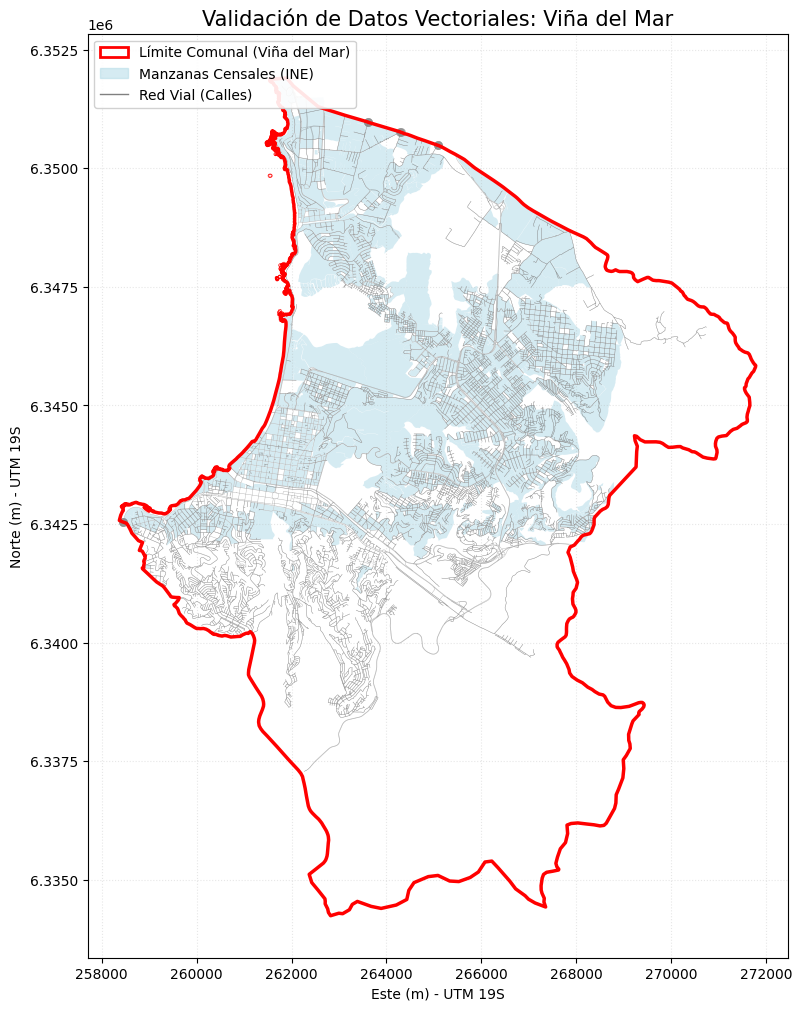

In [11]:
# Celda 3: Validación Visual de Vectores (FINAL PARA INFORME)
# ======================================================
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Definir rutas de entrada
vector_dir = project_root / "data" / "vector"
limite_path = vector_dir / "limite_comuna.gpkg"
manzanas_path = vector_dir / "manzanas_censales.shp"
vias_path = vector_dir / "red_vial.geojson"

try:
    # 1. Cargar datos
    print("⏳ Cargando vectores...")
    gdf_limite = gpd.read_file(limite_path)
    gdf_manzanas = gpd.read_file(manzanas_path)
    gdf_vias = gpd.read_file(vias_path)

    # 2. REPARACIÓN DE COORDENADAS
    target_crs = "EPSG:32719"
    if gdf_limite.crs.to_string() != target_crs: gdf_limite = gdf_limite.to_crs(target_crs)
    if gdf_manzanas.crs.to_string() != target_crs: gdf_manzanas = gdf_manzanas.to_crs(target_crs)
    if gdf_vias.crs.to_string() != target_crs:
        print(f"⚠️ Red Vial estaba en {gdf_vias.crs}. Reproyectando...")
        gdf_vias = gdf_vias.to_crs(target_crs)

    print("✅ Todos los vectores alineados en EPSG:32719.")

    # 3. Recortar vías
    try:
        gdf_vias = gpd.clip(gdf_vias, gdf_limite)
    except:
        pass 

    # 4. Visualización
    fig, ax = plt.subplots(figsize=(12, 12)) 
    
    # Capas
    gdf_manzanas.plot(ax=ax, color='lightblue', alpha=0.5, zorder=1)
    gdf_vias.plot(ax=ax, color='gray', linewidth=0.3, alpha=0.6, zorder=2)
    gdf_limite.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2.5, zorder=3)

    # Leyenda
    leyenda_elementos = [
        mpatches.Patch(facecolor='none', edgecolor='red', linewidth=2, label='Límite Comunal (Viña del Mar)'),
        mpatches.Patch(color='lightblue', alpha=0.5, label='Manzanas Censales (INE)'),
        mlines.Line2D([], [], color='gray', linewidth=1, label='Red Vial (Calles)')
    ]
    ax.legend(handles=leyenda_elementos, loc='upper left', fontsize=10, frameon=True, framealpha=0.9)

    # Ajustes
    ax.set_aspect('equal') 
    plt.title("Validación de Datos Vectoriales: Viña del Mar", fontsize=15)
    plt.xlabel("Este (m) - UTM 19S")
    plt.ylabel("Norte (m) - UTM 19S")
    plt.grid(True, linestyle=':', alpha=0.3)
    
    # --- GUARDADO AUTOMÁTICO ---
    output_filename = "01_validacion_vectores.png"
    save_path = output_dirs["maps"] / output_filename
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Mapa guardado exitosamente en: {save_path}")
    
    plt.show()

except Exception as e:
    print(f"❌ Error visualizando: {e}")

📂 Encontradas 7 imágenes. Generando panel de control...
💾 Figura guardada exitosamente en: D:\laboratorio_cambio_urbano\outputs\figures\01_serie_temporal_sentinel.png


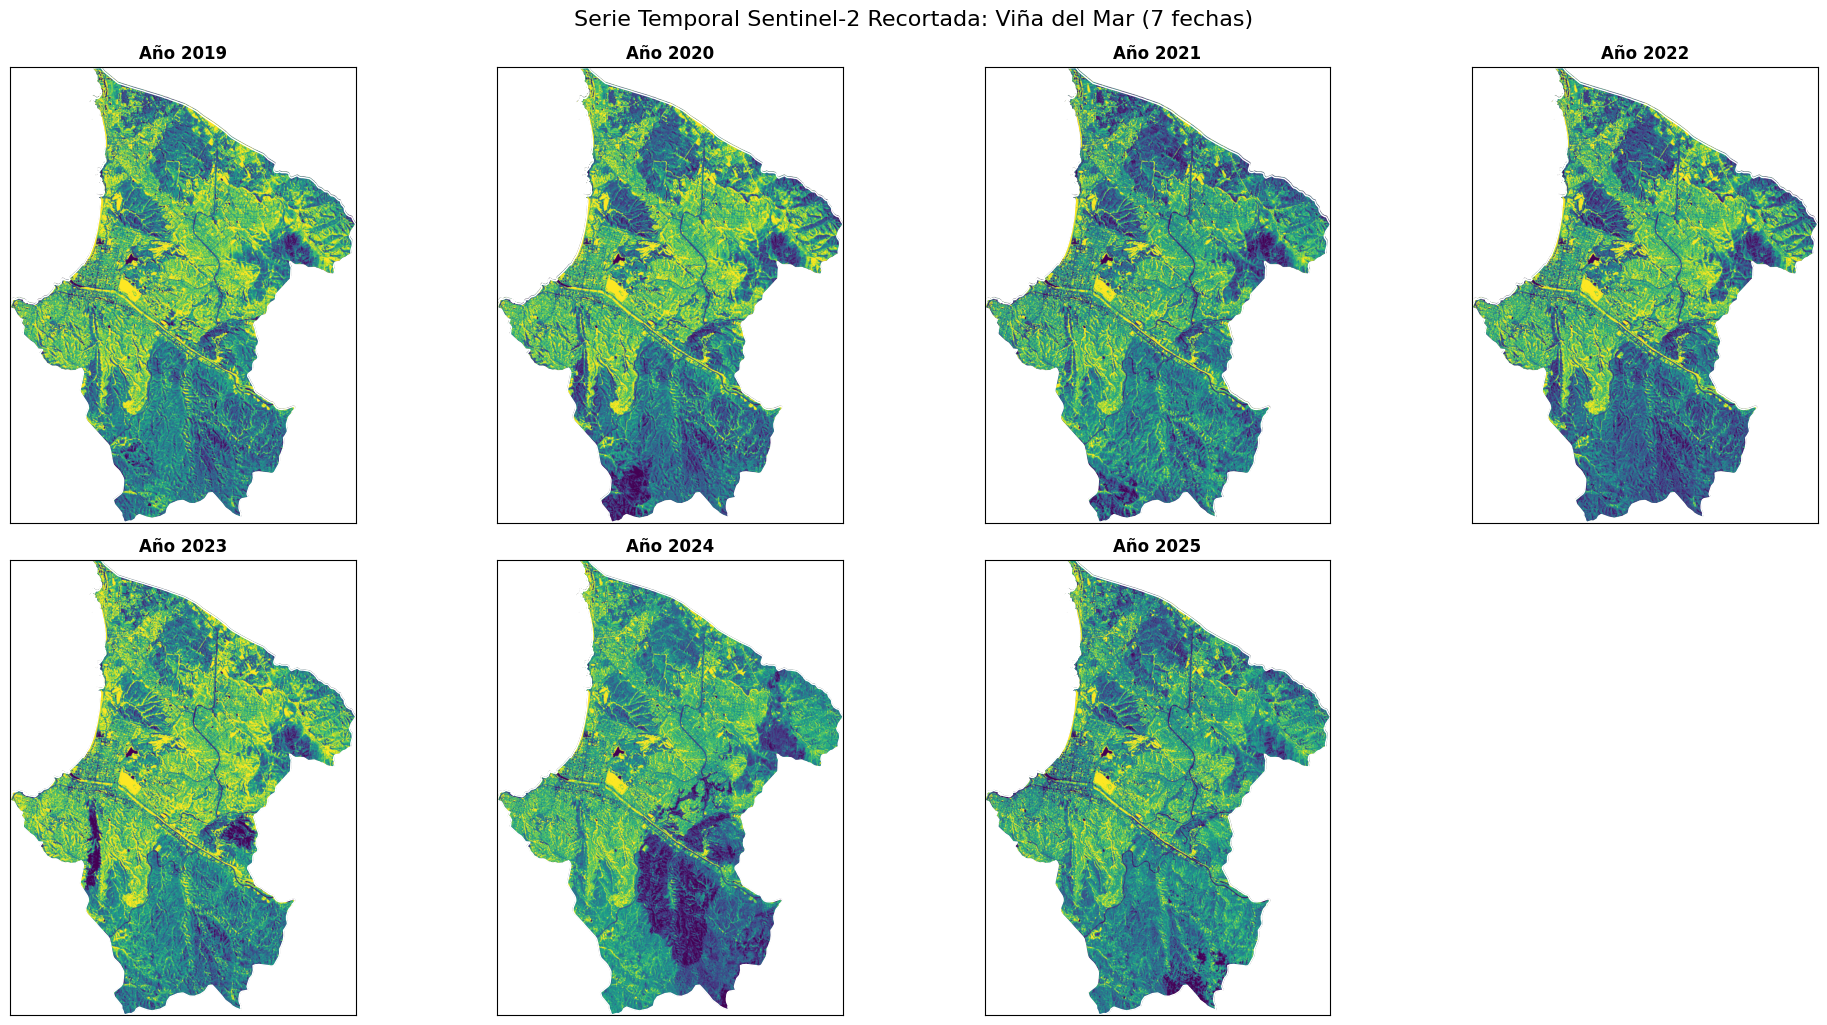

In [12]:
# Celda 4: Visualización de Serie Temporal Recortada (Masking)
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask

# Configuración
raw_dir = project_root / "data" / "raw"
imagenes = sorted(list(raw_dir.glob("sentinel2_*.tif")))
vector_path = project_root / "data" / "vector" / "limite_comuna.gpkg"
gdf_limite = gpd.read_file(vector_path)

if not imagenes:
    print("❌ No hay imágenes.")
else:
    print(f"📂 Encontradas {len(imagenes)} imágenes. Generando panel de control...")

    # Configurar el gráfico
    cols = 4
    rows = 2
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()

    for idx, img_path in enumerate(imagenes):
        ax = axes[idx]
        year = img_path.stem.split("_")[1]
        
        with rasterio.open(img_path) as src:
            if gdf_limite.crs != src.crs:
                gdf_limite = gdf_limite.to_crs(src.crs)
            
            # Recorte (Masking)
            shapes = [geom for geom in gdf_limite.geometry]
            out_image, out_transform = mask(src, shapes, crop=True)
            
            nir = out_image[3].astype(float) # Banda NIR
            
            # Limpieza
            nir[nir <= 0] = np.nan
            nir[np.isinf(nir)] = np.nan
            
            # Visualización
            if np.nanmax(nir) > 0:
                vmin, vmax = np.nanpercentile(nir, [2, 98])
                show(nir, transform=out_transform, ax=ax, cmap='viridis', 
                     vmin=vmin, vmax=vmax)
                ax.set_title(f"Año {year}", fontsize=12, fontweight='bold')
                gdf_limite.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=1)
            else:
                ax.set_title(f"{year} (VACÍA)", color='red')
            
            ax.set_xticks([])
            ax.set_yticks([])

    for i in range(len(imagenes), rows * cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.suptitle(f"Serie Temporal Sentinel-2 Recortada: Viña del Mar ({len(imagenes)} fechas)", fontsize=16, y=1.02)
    
    # --- GUARDADO AUTOMÁTICO ---
    output_filename = "01_serie_temporal_sentinel.png"
    save_path = output_dirs["figures"] / output_filename
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Figura guardada exitosamente en: {save_path}")
    
    plt.show()